In [2]:
!pip install -q pymoo numpy matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.figsize": (6, 5)})
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from pymoo.util.ref_dirs import get_reference_directions


In [4]:
PROBLEMS = [("zdt1", 2),("zdt3", 2),("dtlz2", 3),]

ALGORITHMS = {
    "NSGA2": lambda pop, nobj: NSGA2(pop_size=pop),
    "MOEAD": lambda pop, nobj: MOEAD(
        ref_dirs=build_ref_dirs(nobj, pop),
        n_neighbors=15
    ),
}

N_EVALS  = 10_000
POP_SIZE = 100
SEEDS    = [12, 123, 456]

OUT_DIR = "salidas_pymoo"
os.makedirs(OUT_DIR, exist_ok=True)

print("Problemas:", PROBLEMS)
print("Algoritmos:", list(ALGORITHMS.keys()))
print("N_EVALS:", N_EVALS, "| POP_SIZE:", POP_SIZE, "| SEEDS:", SEEDS)


Problemas: [('zdt1', 2), ('zdt3', 2), ('dtlz2', 3)]
Algoritmos: ['NSGA2', 'MOEAD']
N_EVALS: 10000 | POP_SIZE: 100 | SEEDS: [12, 123, 456]


In [5]:


def build_ref_dirs(n_obj: int, n_points: int):
    try:
        return get_reference_directions("energy", n_obj, n_points=n_points)
    except Exception:
        best, best_diff = None, 10**9
        for p in range(4, 30):
            try:
                cand = get_reference_directions("das-dennis", n_obj, n_partitions=p)
                diff = abs(len(cand) - n_points)
                if diff < best_diff:
                    best, best_diff = cand, diff
            except Exception:
                pass
        return best

def ref_point_for(problem_name: str, n_obj: int):
    if n_obj == 2:  return np.array([1.2, 1.2])
    if n_obj == 3:  return np.array([2.0, 2.0, 2.0])
    return np.ones(n_obj) * 2.0

def get_pf(problem_name: str, n_obj: int, n_points: int = 1000):
    problem = get_problem(problem_name)
    for kwargs in ({"n_points": n_points}, {"n_pareto_points": n_points}, {}):
        try:
            pf = problem.pareto_front(**kwargs)
            if pf is not None:
                return pf
        except TypeError:
            pass
    if problem_name.lower() == "dtlz2":
        rng = np.random.default_rng(42)
        X = rng.random((n_points, n_obj)) + 1e-9
        X = X / np.linalg.norm(X, axis=1, keepdims=True)
        return X
    return None

def compute_metrics(F, problem_name: str, n_obj: int):
    pf = get_pf(problem_name, n_obj, n_points=1000)
    if pf is None:
        igd_val = np.nan
    else:
        igd_val = float(IGD(pf)(F))

    ref = ref_point_for(problem_name, n_obj)
    hv_val = float(HV(ref_point=ref)(F))

    return igd_val, hv_val


def run_once(problem_name: str, n_obj: int, algo_name: str, pop_size: int, seed: int):
    problem = get_problem(problem_name)
    algorithm = ALGORITHMS[algo_name](pop_size, n_obj)
    termination = get_termination("n_evals", N_EVALS)

    res = minimize(problem, algorithm, termination=termination,
                   seed=seed, save_history=True, verbose=False)

    F = res.F
    igd_val, hv_val = compute_metrics(F, problem_name, n_obj)
    ref = ref_point_for(problem_name, n_obj)
    hv_ind = HV(ref_point=ref)
    hist_hv = []
    for e in res.history:
        if hasattr(e, "pop") and e.pop is not None:
            hist_hv.append(float(hv_ind(e.pop.get("F"))))

    return {"F": F, "igd": igd_val, "hv": hv_val, "hist_hv": np.array(hist_hv)}


In [6]:
rows = []
best_fronts = {}

for (pname, nobj) in PROBLEMS:
    for algo in ALGORITHMS.keys():
        best_hv = -np.inf
        for seed in SEEDS:
            out = run_once(pname, nobj, algo, POP_SIZE, seed)
            rows.append({
                "problem": pname, "n_obj": nobj, "algorithm": algo,
                "seed": seed, "igd": out["igd"], "hv": out["hv"],
                "n_evals": N_EVALS, "pop_size": POP_SIZE
            })
            if out["hv"] > best_hv:
                best_hv = out["hv"]
                best_fronts[(pname, algo)] = {"F": out["F"], "hist_hv": out["hist_hv"]}

df_runs = pd.DataFrame(rows)
df_runs.to_csv(f"{OUT_DIR}/resultados_por_corrida.csv", index=False)
df_runs


,problem,n_obj,algorithm,seed,igd,hv,n_evals,pop_size
0,zdt1,2,NSGA2,12,0.017637,1.073496,10000,100
1,zdt1,2,NSGA2,123,0.017216,1.074774,10000,100
2,zdt1,2,NSGA2,456,0.017060,1.074866,10000,100
3,zdt1,2,MOEAD,12,0.014806,1.076102,10000,100
4,zdt1,2,MOEAD,123,0.015702,1.072370,10000,100
5,zdt1,2,MOEAD,456,0.019925,1.064451,10000,100
6,zdt3,2,NSGA2,12,0.014900,1.590298,10000,100
7,zdt3,2,NSGA2,123,0.013621,1.594996,10000,100
8,zdt3,2,NSGA2,456,0.012423,1.599128,10000,100
9,zdt3,2,MOEAD,12,0.049232,1.544474,10000,100


In [7]:
def resumen(df):
    return (df.groupby(["problem","n_obj","algorithm"])
              .agg(igd_med=("igd","median"),
                   igd_std=("igd","std"),
                   hv_med=("hv","median"),
                   hv_std=("hv","std"),
                   runs=("igd","count"))
              .reset_index()
              .sort_values(["problem","algorithm"]))

df_summary = resumen(df_runs)
df_summary.to_csv(f"{OUT_DIR}/tabla_comparativa.csv", index=False)
df_summary


,problem,n_obj,algorithm,igd_med,igd_std,hv_med,hv_std,runs
0,dtlz2,3,MOEAD,0.049620,0.000540,7.408639,0.004553,3
1,dtlz2,3,NSGA2,0.074373,0.001757,7.349084,0.021173,3
2,zdt1,2,MOEAD,0.015702,0.002734,1.072370,0.005950,3
3,zdt1,2,NSGA2,0.017216,0.000299,1.074774,0.000766,3
4,zdt3,2,MOEAD,0.068573,0.021893,1.501376,0.058315,3
5,zdt3,2,NSGA2,0.013621,0.001239,1.594996,0.004418,3


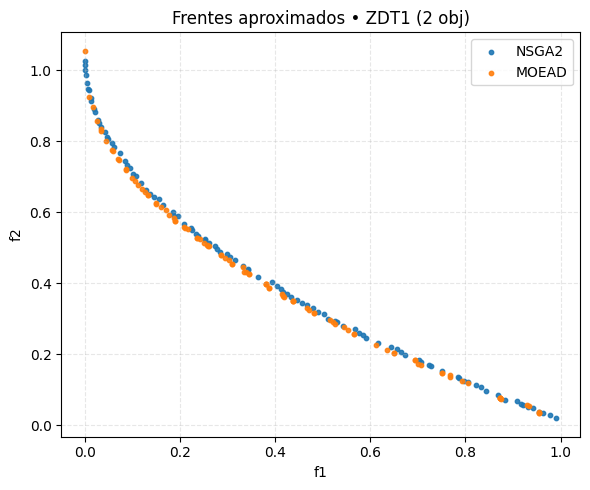

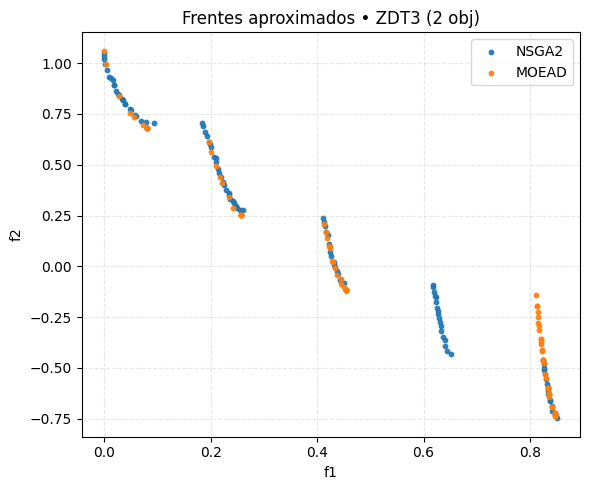

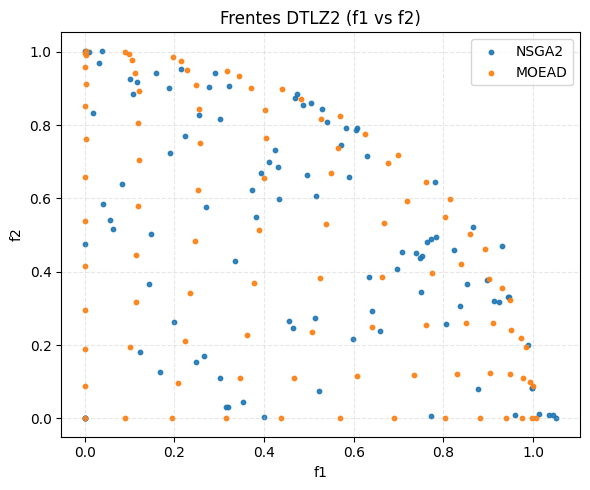

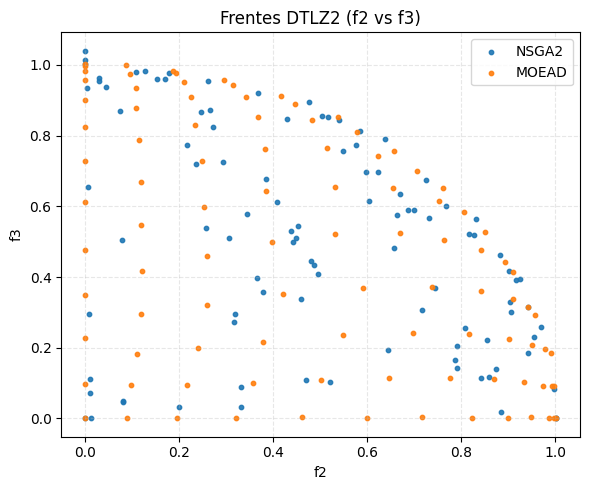

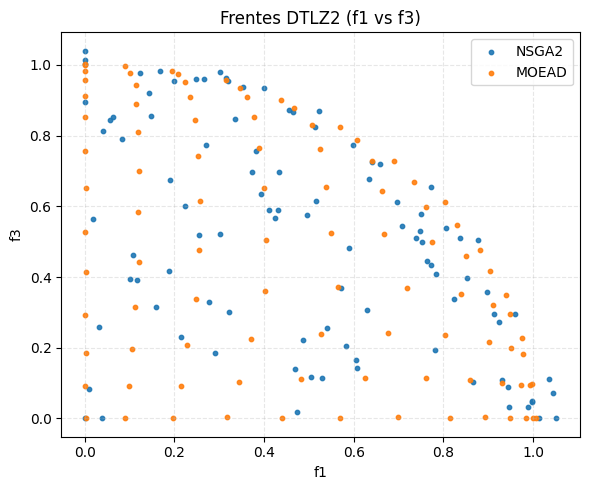

In [8]:
def plot_fronts(problem_name: str, n_obj: int):
    if n_obj == 2:
        plt.figure()
        for algo in ALGORITHMS.keys():
            F = best_fronts[(problem_name, algo)]["F"]
            plt.scatter(F[:,0], F[:,1], s=10, label=algo, alpha=0.9)
        plt.title(f"Frentes aproximados • {problem_name.upper()} (2 obj)")
        plt.xlabel("f1"); plt.ylabel("f2"); plt.grid(True, ls="--", alpha=0.3)
        plt.legend(); plt.tight_layout()
        plt.savefig(f"{OUT_DIR}/frente_{problem_name}.png", dpi=150)
        plt.show()
    elif n_obj == 3:
        for (i,j) in [(0,1),(1,2),(0,2)]:
            plt.figure()
            for algo in ALGORITHMS.keys():
                F = best_fronts[(problem_name, algo)]["F"]
                plt.scatter(F[:,i], F[:,j], s=10, label=algo, alpha=0.9)
            plt.title(f"Frentes {problem_name.upper()} (f{i+1} vs f{j+1})")
            plt.xlabel(f"f{i+1}"); plt.ylabel(f"f{j+1}"); plt.grid(True, ls="--", alpha=0.3)
            plt.legend(); plt.tight_layout()
            plt.savefig(f"{OUT_DIR}/frente_{problem_name}_f{i+1}_f{j+1}.png", dpi=150)
            plt.show()

for (pname, nobj) in PROBLEMS:
    plot_fronts(pname, nobj)


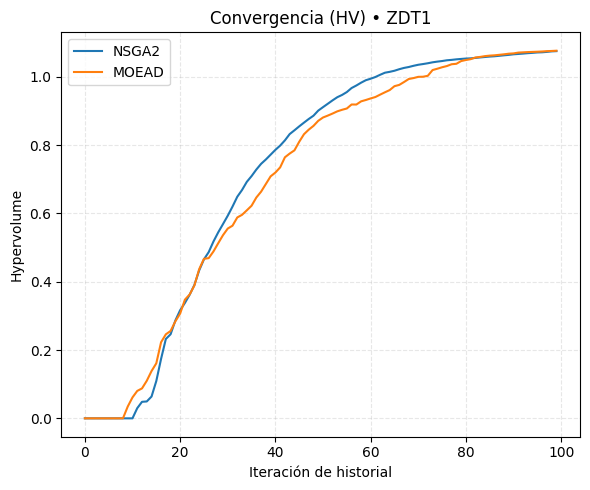

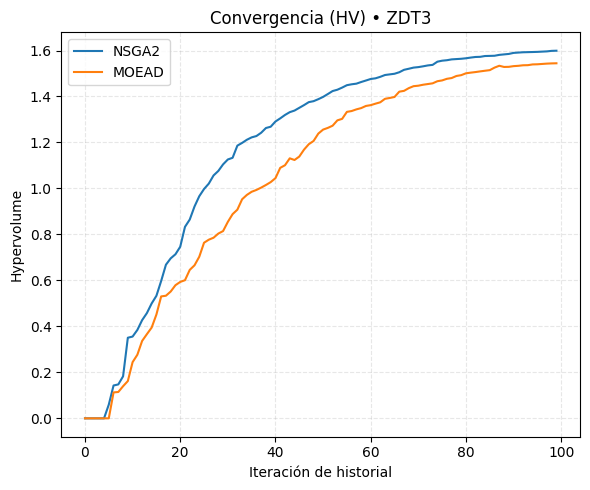

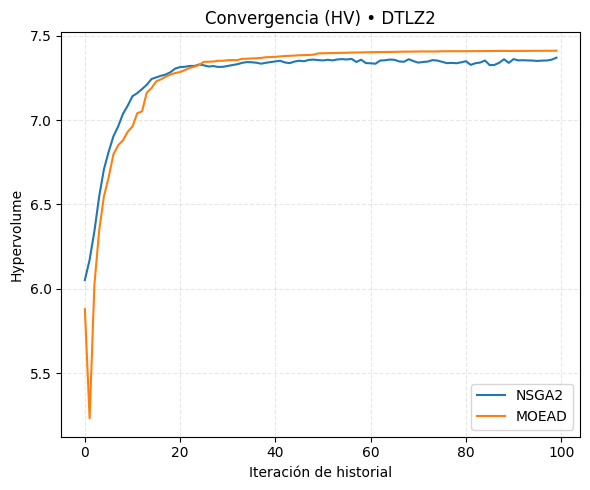

In [9]:
for (pname, nobj) in PROBLEMS:
    plt.figure()
    for algo in ALGORITHMS.keys():
        hv_series = best_fronts[(pname, algo)]["hist_hv"]
        if len(hv_series) > 0:
            plt.plot(hv_series, label=algo)
    plt.title(f"Convergencia (HV) • {pname.upper()}")
    plt.xlabel("Iteración de historial"); plt.ylabel("Hypervolume")
    plt.grid(True, ls="--", alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/convergencia_{pname}.png", dpi=150)
    plt.show()
